## Подгрузка библиотек


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
!pip install fiona
import fiona
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 3.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 2.5 MB/s 
     |████████████████████████████████| 58 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 7.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=b65c2208a7a3c91071eddad0e491e4d78e278ff5fd67530fad7ffe1f1e591218
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3a5e20c4c91c7a1faa6167467e665ef9476bef8f2a7b326134d87c5c59370c6d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully 

## Датасет


In [ ]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")
    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod 
    def parse_polygon(coordinates, image_size): 
        mask = np.zeros(image_size, dtype=np.float32) 
    
        if len(coordinates) == 1: 
            points = [np.int32(coordinates)] 
            cv2.fillPoly(mask, points, 1) 
        else: 
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
    
            for polygon in coordinates[1:]: 
                points = [np.int32([polygon])] 
                cv2.fillPoly(mask, points, 0) 
    
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        mask = np.zeros(image_size, dtype=np.float32)
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask += EyeDataset.parse_polygon(polygon, image_size)
        else:
            mask += EyeDataset.parse_polygon(coordinates, image_size)

        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1 + max(self.class_ids.values())
        mask_channels = [np.zeros(image_size, dtype=np.float32) for _ in range(num_channels)]
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            channel_id = self.class_ids["vessel"]
            mask = self.parse_mask(shape['geometry'], image_size)
            mask_channels[channel_id] = np.maximum(mask_channels[channel_id], mask)

        mask_channels[0] = 1 - np.max(mask_channels[1:], axis=0)

        return np.stack(mask_channels, axis=-1)

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        json_path = image_path.replace("png", "geojson")

        image = self.read_image(image_path)

        mask = self.read_layout(json_path, image.shape[:2])
        
        sample = {'image': image,
                  'mask': mask}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]
        
        if self.transform is not None:
            sample = self.transform(**sample)
        image=sample['image']
        mask=sample['mask']
        size=256
        cropped_images=np.random.rand((1024*1024)//(size*size),3,size,size)
        cropped_masks=np.random.rand((1024*1024)//(size*size),2,size,size)
        count=0

        for y in range(0,1024, size):
          for x in range(0,1024,size):
            temp=A.Crop(x_min=x, y_min=y, x_max=x+size, y_max=y+size)(image=image)
            cropped_images[count]=temp['image'].T
            temp=A.Crop(x_min=x, y_min=y, x_max=x+size, y_max=y+size)(image=mask)
            cropped_masks[count]=temp['image'].T
            count+=1
        sample = {'image': torch.from_numpy(cropped_images).float(),
                  'mask': torch.from_numpy(cropped_masks).float()}


        return sample
        

    def __len__(self) -> int:
        return len(self.indices)


In [ ]:
# Задаем преобразование изображений
size = 1024
train_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size)]
eval_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/cp_datasets/test_dataset.zip -d test
!unzip -q /content/gdrive/My\ Drive/cp_datasets/train_dataset.zip -d train

In [ ]:
dataset = EyeDataset("/content/train")

In [ ]:
id=0
for filepath in dataset._image_files:
  if 1 - len(glob.glob(filepath.replace("png", "geojson"))) !=0:
    dataset._image_files.pop(id)
  id+=1

In [ ]:
from os import listdir

In [ ]:
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.15)


In [ ]:
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])
print(train_dataset[0]['mask'].shape,valid_dataset[0]['mask'].shape) 

torch.Size([16, 2, 256, 256]) torch.Size([16, 2, 256, 256])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                           num_workers=0,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                           num_workers=0,
                                   shuffle=True, drop_last=True)

## Вспомогательные функции

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict


class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None, PATH):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

        self.PATH=PATH

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:
        predictions = []
        targets = []

        losses = []

        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'][0].to(self.device)
                ys_true = batch['mask'][0].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()

        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """
        self.extra_ind = []
        self.optimizer.zero_grad()

        predictions = []
        targets = []

        for real_batch_number in range(update_every_n_batches):
            try:
                batch = next(train_iterator)

                xs = batch['image'][0].to(self.device)
                ys_true = batch['mask'][0].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)
            pred_rows = []
            true_rows = []
            size = 256
            for min_id in range(0, (1024 * 1024) // (size * size), 1024 // size):
                img_row = [torch.as_tensor(i).T for i in ys_pred[min_id: min_id + 1024 // size]]
                img_row = torch.hstack(img_row)
                pred_rows.append(img_row)
                true_row = [torch.as_tensor(i).T for i in ys_true[min_id: min_id + 1024 // size]]
                true_row = torch.hstack(true_row)
                true_rows.append(true_row)
            ys_true = torch.vstack([i for i in true_rows]).T
            ys_pred = torch.vstack([i for i in pred_rows]).T

            loss = self.criterion(ys_pred, ys_true)
            (loss / update_every_n_batches).backward()

            self.losses.append(loss.item())

            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())

        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(self.losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        self.losses=self.losses
        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0
        
        train_iterator = iter(train_loader)
        self.losses = []
        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)
            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1
        self.losses = np.asarray(self.losses)
        
        print(self.losses.shape)
        for i in range(10):
            ind = np.argmin(self.losses)
            losses = np.delete(self.losses, ind)
            self.extra_ind.append(ind)
        extra_train_iterator=iter(train_loader)
        self.extra_train(extra_train_iterator)
        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches
        return metrics

    def fit(self, train_loader, num_epochs: int,
            val_loader=None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
            # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)

            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary

    def extra_train(self, train_iterator):
        self.model.train()
        with tqdm(total=10) as pbar:
          for i in range(max(self.extra_ind)):
              if i in self.extra_ind:

                  batch = next(train_iterator)

                  xs = batch['image'][0].to(self.device)
                  ys_true = batch['mask'][0].to(self.device)

                  ys_pred = self.model.train()(xs)

                  pred_rows = []
                  true_rows = []
                  size = 256
                  for min_id in range(0, (1024 * 1024) // (size * size), 1024 // size):
                      img_row = [torch.as_tensor(i).T for i in ys_pred[min_id: min_id + 1024 // size]]
                      img_row = torch.hstack(img_row)
                      pred_rows.append(img_row)
                      true_row = [torch.as_tensor(i).T for i in ys_true[min_id: min_id + 1024 // size]]
                      true_row = torch.hstack(true_row)
                      true_rows.append(true_row)
                  ys_true = torch.vstack([i for i in true_rows]).T
                  ys_pred = torch.vstack([i for i in pred_rows]).T

                  loss = self.criterion(ys_pred, ys_true)

                  loss.backward()
                  self.optimizer.step()
                  pbar.update(1)
              else:
                  next(train_iterator)

        def save_dir(self):
          torch.save(self.model, '/content/save_model.pt')
          shutil.copy('/content/save_model.pt',self.PATH)


In [ ]:
# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-81):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)

# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(predictions)

        return numerator / (denominator + self.epsilon)

def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    accuracy = Accuracy()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_accuracy(pred, target):
        return accuracy(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('dice', exp_dice),
            ('accuracy', exp_accuracy),
            ('recall', exp_recall),
            ]
    

## Обучение модели и сохранение

In [ ]:
model = smp.UnetPlusPlus(encoder_name='resnet152', encoder_weights='imagenet' , activation='logsoftmax', classes=2).cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

criterion = make_criterion()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 0.00001)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Обучаем модель
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=make_metrics())
summary = trainer.fit(train_loader, 8, val_loader=valid_loader)

## Загрузка модели

In [ ]:
model = torch.load(PATH)

## Посмотрим метрики обученной модели на валидационном датасете

In [ ]:
summary

{'loss_train': array([0.15500257, 0.01888907, 0.0119652 , 0.00902441, 0.00822477,
        0.00798329, 0.00719022, 0.0068791 , 0.00624083, 0.00585641,
        0.0056319 , 0.00556039]),
 'dice_train': array([0.92289451, 0.9837701 , 0.98889423, 0.99077701, 0.99171008,
        0.99231634, 0.99285624, 0.99323499, 0.99363799, 0.99397432,
        0.99423456, 0.99442601]),
 'accuracy_train': array([0.92289451, 0.9837701 , 0.98889423, 0.99077701, 0.99171008,
        0.99231634, 0.99285624, 0.99323499, 0.99363799, 0.99397432,
        0.99423456, 0.99442601]),
 'recall_train': array([0.92289451, 0.9837701 , 0.98889423, 0.99077701, 0.99171008,
        0.99231634, 0.99285624, 0.99323499, 0.99363799, 0.99397432,
        0.99423456, 0.99442601]),
 'loss_test': array([0.97761524, 0.77414834, 0.64534125, 0.58286016, 0.5284497 ,
        0.50063579, 0.51878923, 0.51279415, 0.52302887, 0.47199203,
        0.48368909, 0.4689635 ]),
 'dice_test': array([0.02238476, 0.22585166, 0.35465875, 0.41713984, 0.4715

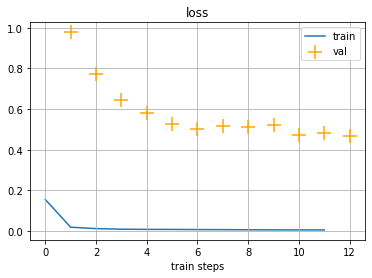

In [ ]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

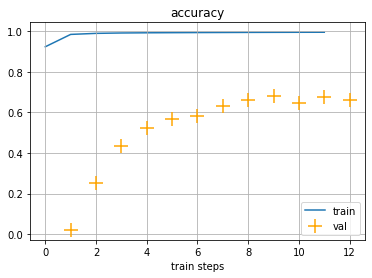

In [ ]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

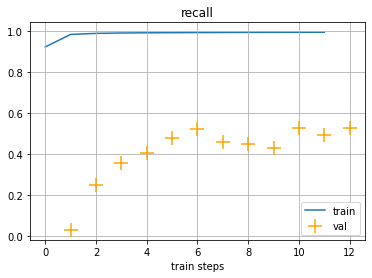

In [ ]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

RuntimeError: ignored

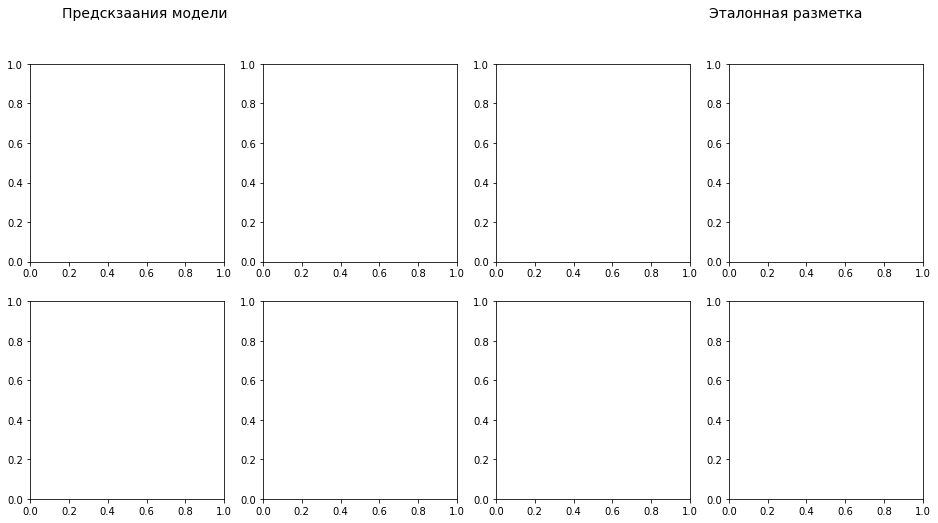

In [ ]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model.eval()(image.unsqueeze(dim=0))

    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.5).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_ask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)

# Предсказание изображений

In [ ]:
i_size=256

In [ ]:
class TestDataset:
  def __init__(self, files):
    self.files=files
    size=1024
    self.transforms=A.Compose([A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size)])
  def load_image(self,file):
    image = cv2.imread(str(file), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image / 255, dtype=np.float32)
    image = self.transforms(image=image)
    image = image['image']
    cropped_image=np.random.rand((1024*1024)//(i_size*i_size),3,i_size,i_size)      
    count=0
    for y in range(0,1024, i_size):
      for x in range(0,1024,i_size):
        temp=A.Crop(x_min=x, y_min=y, x_max=x+i_size, y_max=y+i_size)(image=image)
        cropped_image[count]=temp['image'].T
        count+=1
    return {'image': torch.from_numpy(cropped_image).float()}
  def __getitem__(self, index):
    return self.load_image('/content/test/eye_test/'+str(self.files[index]))
  def __len__(self):
    return len(self.files)

In [ ]:
class Predictor():
  def __init__(self, model,dataset):
    self.model=model
    self.dataset=dataset
  def predict(self):
    self.predictions=[]
    self.model=self.model.to('cuda')
    model.eval()
    for image in self.dataset:
      with torch.no_grad():
        c_img=image['image'].to('cuda')
        pred = model(c_img).cpu()
        del c_img
        gc.collect()
        pred_mask = (torch.exp(pred) > 0.5)
        self.predictions.append(pred_mask)
        del pred_mask
        gc.collect()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
test_dataset=TestDataset(listdir('/content/test/eye_test'))
predictor=Predictor(model, test_dataset)
predictor.predict()

In [ ]:
size=256

In [ ]:
for i in range(len(test_dataset)):
  np_image=predictor.predictions[i].numpy().astype(np.uint8)
  img_rows=[]
  for min_id in range(0, (1024*1024)//(size*size), 1024//size):
    img_row = np.hstack( (np.asarray(i).T for i in np_image[min_id: min_id+1024//size] ) )
    img_rows.append(img_row)
  np_image = np.vstack( ( i for i in img_rows ) )
  np_image=A.CenterCrop(777, 1024)(image=np_image)
  np_image=A.SmallestMaxSize(max_size=1232)(image=np_image['image'])
  np_image=np_image['image'].T[1].T
  cv2.imwrite(f'/content/predicts/{test_dataset.files[i]}', np_image*255)

In [ ]:
!zip -r '/content/predicts.zip' '/content/predicts'

updating: content/predicts/ (stored 0%)
updating: content/predicts/1087.png (deflated 29%)
updating: content/predicts/1102.png (deflated 29%)
updating: content/predicts/877.png (deflated 31%)
updating: content/predicts/1098.png (deflated 21%)
updating: content/predicts/906.png (deflated 26%)
updating: content/predicts/1094.png (deflated 27%)
updating: content/predicts/1113.png (deflated 21%)
updating: content/predicts/1088.png (deflated 29%)
updating: content/predicts/931.png (deflated 91%)
updating: content/predicts/1107.png (deflated 44%)
updating: content/predicts/832.png (deflated 28%)
updating: content/predicts/837.png (deflated 39%)
updating: content/predicts/1009.png (deflated 44%)
updating: content/predicts/969.png (deflated 30%)
updating: content/predicts/853.png (deflated 47%)
updating: content/predicts/1085.png (deflated 21%)
updating: content/predicts/1062.png (deflated 42%)
updating: content/predicts/1039.png (deflated 56%)
updating: content/predicts/1105.png (deflated 34%